In [96]:
path = '/home/arunava'
#****************************To be Change to reproduce ou result*********************************************

# location of the data and where to store iamge feature image
path_output_chd = path+'/VQA_Med'    

input_vqa_train = 'train_dataset_pickle/train20_subset19_df.pkl'
input_vqa_valid ='valid_dataset_pickle/val20_df.pkl'

img_feat_train = 'train_dataset_pickle/train-image-feature-20-subset19.pickle'
img_feat_valid ='valid_dataset_pickle/valid-image-feature-20-subset19.pickle'

input_test = 'test_dataset_pickle/test_val21_df.pkl'
img_feat_test = 'test_dataset_pickle/test-image-feature-21.pickle'


In [97]:
import json
import numpy as np
with open(path+'/VQA_Med/answer_classes_2020_subset19.json', 'r') as j:
        answer_classes = json.load(j)


l = len(answer_classes) 

print(l)

import easydict
opt = easydict.EasyDict({
        "SEED":97,
        "BATCH_SIZE": 64,
        "VAL_BATCH_SIZE": 64,
        "NUM_OUTPUT_UNITS": l,
        "MAX_QUESTION_LEN": 17,
        "IMAGE_CHANNEL": 768,
        "INIT_LEARNING_RATE": 1e-4,
        "LAMNDA":0.0001,
        "MFB_FACTOR_NUM":5,
        "MFB_OUT_DIM":1000,
        "BERT_UNIT_NUM":768,
        "BERT_DROPOUT_RATIO":0.3,
        "MFB_DROPOUT_RATIO":0.1,
        "NUM_IMG_GLIMPSE":2,
        "NUM_QUESTION_GLIMPSE":2,
        "IMG_FEAT_SIZE":1,
        "IMG_INPUT_SIZE":224,
        "NUM_EPOCHS":150,
    })

333


In [98]:
import numpy as np
from torch.utils.data import DataLoader
import easydict
import nltk
import numpy as np
import random
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertTokenizer
from transformers import BertModel
import time
import re
from torchinfo import summary
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate import bleu_score
import os
import matplotlib.pyplot as plt
import nltk
import copy
import pandas as pd
from torch.utils.data import DataLoader

from transformers import VisualBertModel, VisualBertConfig
from transformers import AutoTokenizer, AutoModel

In [99]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print('device',device)

nltk.download('punkt')

device cuda:5


[nltk_data] Downloading package punkt to /home/arunava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
seed_value = opt.SEED
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value) # return <torch._C.Generator object at 0x7f71cdf7a3d0>
torch.cuda.manual_seed(seed_value) 
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [101]:
class VqaDataset(data.Dataset):
    '''
        Main class use to retrieve our dataset from pickle file.
    '''

    def __init__(self, input_dir, input_vqa, img_feat_vqa, transform=None, phase = 'train'):
        # print('vqa_path',input_dir+'/'+input_vqa)
        # print('feat_path',input_dir+'/'+img_feat_vqa)
        self.input_dir = input_dir
        self.vqa = np.load(input_dir+'/'+input_vqa, allow_pickle=True )
        self.img_feat_vqa = np.load(input_dir+'/'+img_feat_vqa, allow_pickle=True )
        self.vocab_size = None
        self.phase = phase
        # print('vqa',self.vqa)
        # print('img_feat_vqa',type(self.img_feat_vqa))
   

    def __getitem__(self, idx):

        vqa = self.vqa
        img_feat_vqa = self.img_feat_vqa
        image_id = vqa['ID'].values[idx]
        image_feat = torch.Tensor(img_feat_vqa[image_id])
        sample = { 'image_feature':image_feat ,  } 
        if (self.phase == 'train' or self.phase == 'valid'):
            qst2dic = vqa['Q'].values[idx]  
            answer = vqa['A'].values[idx]
            label = vqa['labels'].values[idx]
            sample['question'] = qst2dic
            sample['answer'] = answer
            sample['label'] = label
        else:
            sample['image_id'] = image_id
            sample['question'] = vqa['Q'].values[idx]
        return sample

    def __len__(self):

        return len(self.vqa)

In [102]:
def get_loader(input_dir, input_vqa_train, input_vqa_valid, img_feat_train, img_feat_valid, batch_size, num_workers,size=228):
    '''
        Load our dataset with dataloader for the train and valid data
    '''

    vqa_dataset = {
        'train': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_train,
            img_feat_vqa=img_feat_train,
            phase = 'train'),
        'valid': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_valid,
            img_feat_vqa=img_feat_valid,
            phase = 'valid')}
    

    data_loader = {
        phase: torch.utils.data.DataLoader(
            dataset=vqa_dataset[phase],
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            )
        for phase in ['train','valid']}

    return data_loader

In [103]:
class BERTokenizer():

    def __init__(self,opt):
        # Load the BERT tokenizer
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.opt = opt
    #pre-process the text data
    def text_preprocessing(self, text):

        # Remove trailing whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text


    # Create a function to tokenize a set of texts
    def preprocessing_for_bert(self, data):
        """Perform required preprocessing steps for pretrained BERT.
        @param    data (np.array): Array of texts to be processed.
        @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
        @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                    tokens should be attended to by the model.
        """
        # Create empty lists to store outputs
        input_ids = []
        attention_masks = []
        MAX_LEN = self.opt.MAX_QUESTION_LEN
        # For every sentence...
        for sent in data:
            
            encoded_sent = self.tokenizer.encode_plus(
                text=self.text_preprocessing(sent),  # Preprocess sentence
                add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
                max_length=MAX_LEN,                  # Max length to truncate/pad
                pad_to_max_length=True,         # Pad sentence to max length
                #return_tensors='pt',           # Return PyTorch tensor
                truncation=True,
                return_attention_mask=True      # Return attention mask
                )
            
            # Add the outputs to the lists
            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        # Convert lists to tensors
        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        inputs = { 'input_ids' : input_ids, 'attention_mask': attention_masks }

        return inputs

In [104]:
#Extract the question feature with co-attention
class QuestionFeatureExtractionAtt(nn.Module):
    '''
        Extract the question with co-attention, get from https://github.com/asdf0982/vqa-mfb.pytorch 
    '''

    def __init__(self,opt):

        super(QuestionFeatureExtractionAtt, self).__init__()

        self.opt = opt
        self.NUM_QUESTION_GLIMPSE = self.opt.NUM_QUESTION_GLIMPSE #2
                                          # 5                    #1000
        self.JOINT_EMB_SIZE = self.opt.MFB_FACTOR_NUM * self.opt.MFB_OUT_DIM
        self.Softmax = nn.Softmax(dim=-1)
                                                    #768                       #2
        self.Linear1_q_proj = nn.Linear(self.opt.BERT_UNIT_NUM* self.opt.NUM_QUESTION_GLIMPSE, self.JOINT_EMB_SIZE)
        self.Linear2_q_proj = nn.Linear(self.opt.BERT_UNIT_NUM*self.opt.NUM_QUESTION_GLIMPSE, self.JOINT_EMB_SIZE)
        
        self.Dropout_M = nn.Dropout(p=self.opt.MFB_DROPOUT_RATIO)
        self.dropout = nn.Dropout(self.opt.BERT_DROPOUT_RATIO) 
        self.Conv1_Qatt = nn.Conv2d(self.opt.BERT_UNIT_NUM, self.opt.IMAGE_CHANNEL, 1) 
        self.Conv2_Qatt = nn.Conv2d(self.opt.IMAGE_CHANNEL, self.opt.NUM_QUESTION_GLIMPSE, 1)

    def forward(self,qst_encoding):

        '''
        Question Attention
        '''   
        self.batch_size = qst_encoding.shape[0]
        qst_encoding = self.dropout(qst_encoding)
        qst_encoding_resh =  torch.unsqueeze(qst_encoding, 3)       # N=4 x 768 x T=14 x 1     
        qatt_conv1 = self.Conv1_Qatt(qst_encoding_resh)                   # N x 512 x T x 1
        qatt_relu = F.relu(qatt_conv1)
        qatt_conv2 = self.Conv2_Qatt(qatt_relu)                          # N x 2 x T x 1
        qatt_conv2 = qatt_conv2.contiguous().view(self.batch_size*2,-1)
        qatt_softmax = self.Softmax(qatt_conv2)
        qatt_softmax = qatt_softmax.view(self.batch_size, 2, -1, 1)
        qatt_feature_list = []
        for i in range(self.NUM_QUESTION_GLIMPSE):
            t_qatt_mask = qatt_softmax.narrow(1, i, 1)              # N x 1 x T x 1
            t_qatt_mask = t_qatt_mask * qst_encoding_resh           # N x 768 x T x 1
            t_qatt_mask = torch.sum(t_qatt_mask, 2, keepdim=True)   # N x 768 x 1 x 1
            qatt_feature_list.append(t_qatt_mask)
        qatt_feature_concat = torch.cat(qatt_feature_list, 1)       # N x 1536 x 1 x 1

        return qatt_feature_concat

In [105]:
#Extract the image feature with MFB and co-attention 
class ImageFeatureExtractionAtt(nn.Module):

    '''
        Extract the image with co-attention, get from https://github.com/asdf0982/vqa-mfb.pytorch 
    '''

    def __init__(self,opt):
        super(ImageFeatureExtractionAtt, self).__init__()
        self.opt = opt
        self.MFB_FACTOR_NUM = self.opt.MFB_FACTOR_NUM
        self.MFB_OUT_DIM = self.opt.MFB_OUT_DIM
        self.NUM_IMG_GLIMPSE =self.opt.NUM_IMG_GLIMPSE
        self.IMG_FEAT_SIZE = self.opt.IMG_FEAT_SIZE
        
        self.JOINT_EMB_SIZE = self.opt.MFB_FACTOR_NUM * self.opt.MFB_OUT_DIM
        self.Softmax = nn.Softmax(dim=-1)

        self.Linear1_q_proj = nn.Linear(self.opt.BERT_UNIT_NUM* self.opt.NUM_QUESTION_GLIMPSE, self.JOINT_EMB_SIZE)
        self.Linear_i_proj = nn.Linear(self.opt.IMAGE_CHANNEL*self.opt.NUM_IMG_GLIMPSE, self.JOINT_EMB_SIZE)
        self.Conv_i_proj = nn.Conv2d(self.opt.IMAGE_CHANNEL, self.JOINT_EMB_SIZE, 1)
        

        self.Dropout_M = nn.Dropout(p=self.opt.MFB_DROPOUT_RATIO)

        self.Conv1_Iatt = nn.Conv2d(self.opt.MFB_OUT_DIM, self.opt.IMAGE_CHANNEL, 1) # (1000, 512, 1)
        self.Conv2_Iatt = nn.Conv2d(self.opt.IMAGE_CHANNEL, self.NUM_IMG_GLIMPSE, 1)
    
    def forward(self, img_feature, qstatt_feature):

        '''
        Image Attention with MFB
        '''
        self.batch_size = img_feature.shape[0]
        q_feat_resh = torch.squeeze(qstatt_feature)                              # N x 1536
        # print('q_feat_resh',q_feat_resh.shape)
        # print('img_feature',img_feature.shape)
        i_feat_resh = img_feature.unsqueeze(3)                                   # N x 512 x 196 x 1
        # print('i_feat_resh',i_feat_resh.shape)
        iatt_q_proj = self.Linear1_q_proj(q_feat_resh)                                  # N x 5000
        iatt_q_resh = iatt_q_proj.view(self.batch_size, self.JOINT_EMB_SIZE, 1, 1)      # N x 5000 x 1 x 1
        iatt_i_conv = self.Conv_i_proj(i_feat_resh)                                     # N x 5000 x 196 x 1
        iatt_iq_eltwise = iatt_q_resh * iatt_i_conv
        iatt_iq_droped = self.Dropout_M(iatt_iq_eltwise)                                # N x 5000 x 196 x 1
        iatt_iq_permute1 = iatt_iq_droped.permute(0,2,1,3).contiguous()                 # N x 196 x 5000 x 1
        iatt_iq_resh = iatt_iq_permute1.view(self.batch_size, self.IMG_FEAT_SIZE, self.MFB_OUT_DIM, self.MFB_FACTOR_NUM)
        iatt_iq_sumpool = torch.sum(iatt_iq_resh, 3, keepdim=True)                      # N x 196 x 1000 x 1 
        iatt_iq_permute2 = iatt_iq_sumpool.permute(0,2,1,3)                             # N x 1000 x 196 x 1
        iatt_iq_sqrt = torch.sqrt(F.relu(iatt_iq_permute2)) - torch.sqrt(F.relu(-iatt_iq_permute2))
        iatt_iq_sqrt = iatt_iq_sqrt.reshape(self.batch_size, -1)                           # N x 196000
        iatt_iq_l2 = F.normalize(iatt_iq_sqrt)
        iatt_iq_l2 = iatt_iq_l2.view(self.batch_size, self.MFB_OUT_DIM, self.IMG_FEAT_SIZE, 1)  # N x 1000 x 196 x 1

        iatt_conv1 = self.Conv1_Iatt(iatt_iq_l2)                    # N x 512 x 196 x 1
        iatt_relu = F.relu(iatt_conv1)
        iatt_conv2 = self.Conv2_Iatt(iatt_relu)                     # N x 2 x 196 x 1
        iatt_conv2 = iatt_conv2.view(self.batch_size*self.NUM_IMG_GLIMPSE, -1)
        iatt_softmax = self.Softmax(iatt_conv2)
        iatt_softmax = iatt_softmax.view(self.batch_size, self.NUM_IMG_GLIMPSE, -1, 1)
        iatt_feature_list = []
        for i in range(self.NUM_IMG_GLIMPSE):
            t_iatt_mask = iatt_softmax.narrow(1, i, 1)              # N x 1 x 196 x 1
            t_iatt_mask = t_iatt_mask * i_feat_resh                 # N x 512 x 196 x 1
            t_iatt_mask = torch.sum(t_iatt_mask, 2, keepdim=True)   # N x 512 x 1 x 1
            iatt_feature_list.append(t_iatt_mask)
        iatt_feature_concat = torch.cat(iatt_feature_list, 1)       # N x 1024 x 1 x 1
        iatt_feature_concat = torch.squeeze(iatt_feature_concat)    # N x 1024
        return iatt_feature_concat

In [106]:
class VisualBertClassification(nn.Module):
    def __init__(self,opt,num_classes=178,emb_size=768):
        super(VisualBertClassification,self).__init__()
        VBconfig = VisualBertConfig(visual_embedding_dim=1984)
        self.opt = opt
        self.JOINT_EMB_SIZE = self.opt.MFB_FACTOR_NUM * self.opt.MFB_OUT_DIM
        
        self.MFB_OUT_DIM = self.opt.MFB_OUT_DIM
        self.MFB_FACTOR_NUM = self.opt.MFB_FACTOR_NUM
        NUM_OUTPUT_UNITS = self.opt.NUM_OUTPUT_UNITS
        self.tokenizer = BERTokenizer(self.opt)
        self.model = VisualBertModel(VBconfig)
        self.linear_text = nn.Linear(768,emb_size)
        self.linear_img = nn.Linear(768, emb_size)
        self.qst_feature_att = QuestionFeatureExtractionAtt(self.opt)
        self.img_feature_att = ImageFeatureExtractionAtt(self.opt)
        self.Linear2_q_proj = nn.Linear(self.opt.BERT_UNIT_NUM*self.opt.NUM_QUESTION_GLIMPSE, self.JOINT_EMB_SIZE)
        self.Linear_i_proj = nn.Linear(self.opt.IMAGE_CHANNEL*self.opt.NUM_IMG_GLIMPSE, self.JOINT_EMB_SIZE)

        self.Dropout_M = nn.Dropout(p=self.opt.MFB_DROPOUT_RATIO)

        self.Linear_predict = nn.Linear(self.opt.MFB_OUT_DIM, NUM_OUTPUT_UNITS)
        self.classifier = nn.Linear(emb_size*2,num_classes)

    def forward(self,visual_embeds,questions):
        
        # print('visual_embeds',visual_embeds.shape)
        self.batch_size = visual_embeds.shape[0]
        visual_embeds = visual_embeds.transpose(1,2)
        inputs = self.tokenizer.preprocessing_for_bert(questions)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
        # print('visual_token_type_ids',visual_token_type_ids.shape)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float).to(device)
        # print('visual_attention_mask',visual_attention_mask.shape)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
                "output_attentions":True
            }
        ) 
        inputs['input_ids'] = inputs['input_ids'].to(device)
        # inputs['token_type_ids'] = inputs['token_type_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        inputs['visual_token_type_ids'] = inputs['visual_token_type_ids'].to(device)
        inputs['visual_attention_mask'] = inputs['visual_attention_mask'].to(device)

        outputs = self.model(**inputs)
        # print('outputs',outputs[1].shape)
        # print('pooler_output',outputs['pooler_output'].shape)
        # print('out',outputs[1].shape)
        # print('out2',outputs[0][:, 0])
        text_emb = self.linear_text(outputs[0][:,0,:])
        # print('text_emb',text_emb.shape)
        text_emb = text_emb.unsqueeze(-1).repeat(1, 1, 17)
        # print('text_emb',text_emb.shape)
        img_emb = self.linear_img(outputs[1])
        img_emb = img_emb.unsqueeze(-1)
        # print('img_emb',img_emb.shape)
        last_hidden_state = outputs.last_hidden_state
        # combined_emb = torch.cat((img_emb,text_emb),dim=1)
        # print('combined',combined_emb)
        # logits = self.classifier(combined_emb)
        # print('logits',logits)

        # return logits,img_emb,text_emb
        # prediction = self.classifier(outputs['pooler_output'])
        # prediction = F.log_softmax(prediction, -1)
        # return prediction
        q_featatt = self.qst_feature_att(text_emb)      # N x 1536
        # print('q_featatt',q_featatt.shape)
        iatt_feature_concat = self.img_feature_att(img_emb,q_featatt)          # N x 1024
        # print('iatt_feature_concat',iatt_feature_concat.shape)
        '''
        Fine-grained Image-Question MFB fusion
        '''
        q_feat_resh = torch.squeeze(q_featatt)
        mfb_q_proj = self.Linear2_q_proj(q_feat_resh)               # N x 5000
        mfb_i_proj = self.Linear_i_proj(iatt_feature_concat)        # N x 5000
        mfb_iq_eltwise = torch.mul(mfb_q_proj, mfb_i_proj)          # N x 5000
        mfb_iq_drop = self.Dropout_M(mfb_iq_eltwise)
        mfb_iq_resh = mfb_iq_drop.view(self.batch_size, 1, self.MFB_OUT_DIM, self.MFB_FACTOR_NUM)   # N x 1 x 1000 x 5
        mfb_iq_sumpool = torch.sum(mfb_iq_resh, 3, keepdim=True)    # N x 1 x 1000 x 1
        mfb_out = torch.squeeze(mfb_iq_sumpool)                     # N x 1000
        mfb_sign_sqrt = torch.sqrt(F.relu(mfb_out)) - torch.sqrt(F.relu(-mfb_out))
        mfb_l2 = F.normalize(mfb_sign_sqrt)
        prediction = self.Linear_predict(mfb_l2)
        prediction = F.log_softmax(prediction, -1) # N x num_class

        return prediction


In [107]:
def load_checkpoint(model, optimizer, filename=None): 
    # Note: Input model & optimizer should be pre-defined. This routine only updates their states. 
    start_epoch = 0 
    if os.path.isfile(filename): 
        print("=> loading checkpoint '{}'".format(filename)) 
        checkpoint = torch.load(filename) 
        start_epoch = checkpoint['epoch'] 
        model.load_state_dict(checkpoint['state_dict']) 
        optimizer.load_state_dict(checkpoint['optimizer']) 
        print("=> loaded checkpoint '{}' (epoch {})" .format(filename,
                                                            checkpoint['epoch'])) 
    else: print("=> no checkpoint found at '{}'".format(filename)) 
    return model, optimizer, start_epoch

def mixup_criterion_vqa(criterion, pred_a, pred_b, a_a, a_b, lam):
    # print(lam * criterion(pred_a, a_a))
    # print((1 - lam) * criterion(pred_b, a_b))
    # print(lam * criterion(pred_a, a_a) + (1 - lam) * criterion(pred_b, a_b))
    return lam * criterion(pred_a, a_a) + (1 - lam) * criterion(pred_b, a_b)


# def accuracy(output, target_a, target_b, lam, topk=(1,)):
#     """Computes the precision@k for the specified values of k"""
   
#     maxk = max(topk)
#     batch_size = target_a.size(0)

#     _, pred = output.topk(maxk, 1, True, True)
#     pred = pred.t()
   

    
#     if target_a.dim() == 2: # multians option
#         _, target = torch.max(target, 1)
    
#     correct_a = pred.eq(target_a.view(1,-1).expand_as(pred))
#     correct_b = pred.eq(target_b.view(1,-1).expand_as(pred))


    

#     # print(pred.eq(target_a))

#     # correct += (lam * pred.eq(target_a.data).cpu().sum().float()
#     #                 + (1 - lam) * pred.eq(target_b.data).cpu().sum().float())


#     res = []
#     for k in topk:
#         correct_k = lam*correct_a[:k].reshape(-1).float().sum(0) + (1-lam) * correct_b[:k].reshape(-1).float().sum(0)

        
#         res.append((correct_k / batch_size))
   
#     return res

# def get_bleu_score(predicted, true_ans_a,true_ans_b,lam):
#     path_output_change = path_output_chd
#     with open(path_output_change+'/answer_classes.json', 'r') as j:
#         answer_classes_dict = json.load(j)
#     score_a = 0.0
#     score_b = 0.0
#     assert (len(predicted) == len(true_ans_a))
#     assert (len(predicted) == len(true_ans_b))
#     ans_keys = list(answer_classes_dict.keys())
#     ans_values = list(answer_classes_dict.values())
    

#     for pred, true_ans in zip(predicted, true_ans_a):
#         index_ans = ans_values.index(pred)
#         score_a += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)

#     for pred, true_ans in zip(predicted,true_ans_b):
#         index_ans = ans_values.index(pred)

#         score_b += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)
    

#     score = lam * score_a + (1-lam)* score_b
    
#     return score/len(true_ans_a)


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
   
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
   

    
    if target.dim() == 2: # multians option
        _, target = torch.max(target, 1)
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append((correct_k / batch_size))
   
    return res

def get_bleu_score(predicted, true_ans_text):
    path_output_change = path_output_chd
    with open(path_output_change+'/answer_classes_2020_subset19.json', 'r') as j:
        answer_classes_dict = json.load(j)
    score = 0.0
    assert (len(predicted) == len(true_ans_text))
    ans_keys = list(answer_classes_dict.keys())
    ans_values = list(answer_classes_dict.values())
    

    for pred, true_ans in zip(predicted, true_ans_text):
        index_ans = ans_values.index(pred)
        
        score += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)

    return score/len(true_ans_text)



In [108]:
# def contrastive_loss(img_emb, txt_emb, margin=0.5):
#     pos_score = torch.sum(torch.mul(img_emb, txt_emb), dim=1)
#     neg_score = torch.sum(torch.mul(img_emb, torch.roll(txt_emb, shifts=1, dims=0)), dim=1)
#     loss = torch.mean(torch.max(torch.zeros_like(pos_score), pos_score - neg_score + margin))
#     return loss

# def contrastive_loss(img_emb, txt_emb, labels, margin=0.5):
#     # Compute dot product between image and text embeddings
#     dot_prod = torch.matmul(img_emb, txt_emb.t())
#     print('dot_product',labels.shape)
#     # Construct positive and negative mask based on label similarity
#     pos_mask = labels.unsqueeze(1) == labels.unsqueeze(0)
#     print('pos_mask',pos_mask.shape)
#     neg_mask = ~pos_mask
#     # Compute positive and negative scores
#     pos_score = torch.sum(dot_prod * pos_mask.float(), dim=1)
#     neg_score = torch.max(dot_prod * neg_mask.float(), dim=1)[0]
#     # Compute loss as hinge loss between positive and negative scores
#     loss = torch.mean(torch.max(torch.zeros_like(pos_score), pos_score - neg_score + margin))
#     return loss

def contrastive_loss(img_emb, txt_emb, margin=0.5):
    pos_score = torch.sum(torch.mul(img_emb, txt_emb), dim=1)
    neg_score = torch.sum(torch.mul(img_emb, torch.roll(txt_emb, shifts=1, dims=0)), dim=1)
    loss = torch.mean(torch.max(torch.zeros_like(pos_score), pos_score - neg_score + margin))
    return loss

def combined_loss(output, target, img_emb, txt_emb, margin=0.5, ce_weight=0.5):
    ce_loss = nn.CrossEntropyLoss()(output, target)
    cont_loss = contrastive_loss(img_emb, txt_emb, margin=margin)
    # print('cont_loss',cont_loss)
    loss = ce_weight * ce_loss + (1-ce_weight) * cont_loss
    return loss

In [109]:
since = time.time()

best_acc1 = 0.0
best_acc5 = 0.0

best_epoch = 0

list_train_loss_per_epoch = []
list_valid_loss_per_epoch = []

list_train_acc1_per_epoch = []
list_valid_acc1_per_epoch = []

In [110]:
model = VisualBertClassification( opt=opt ).to(device)
criterian = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr = opt.INIT_LEARNING_RATE,weight_decay=opt.LAMNDA)

input_dir =  path_output_chd 
input_vqa_train = input_vqa_train 
input_vqa_valid = input_vqa_valid

img_feat_train =  img_feat_train
img_feat_valid = img_feat_valid

saved_dir =  path_output_chd

In [111]:
num_epochs = opt.NUM_EPOCHS
image_size = opt.IMG_INPUT_SIZE
num_workers = 0
batch_size = opt.BATCH_SIZE

In [112]:
data_loader = get_loader(
        input_dir = input_dir , 
        input_vqa_train = input_vqa_train, 
        input_vqa_valid = input_vqa_valid,
        img_feat_train = img_feat_train, 
        img_feat_valid = img_feat_valid,
            batch_size = batch_size, 
            num_workers = num_workers,
            size = image_size )

In [113]:
for epoch in range(opt.NUM_EPOCHS):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train','valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        top1_acc=0
        top5_acc=0
        bleu=0

        batch_step_size = len(data_loader[phase].dataset) / batch_size
        
        for batch_idx, batch_sample in enumerate(data_loader[phase]):
            # print('batch_sample',batch_sample.keys())
            question = batch_sample['question']
            answer = batch_sample['answer']
            labels = batch_sample['label'].to(device)
            # label_answer_text = batch_sample['answer_text']
            image = batch_sample['image_feature'].to(device)
            # print('image.shape',image.shape)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                logits = model(image,question)
                _, preds = torch.max(logits, 1)
                # loss = contrastive_loss(img_emb,text_emb,labels)
                loss = criterian(logits,labels)
                # loss = combined_loss(logits, labels, img_emb, text_emb)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
            running_loss += loss.item()

            acc1,acc5 = accuracy(logits.data, labels.data, topk=(1, 5))
            top1_acc += acc1
            top5_acc += acc5
            #bleu score
            b = get_bleu_score(preds, answer)
            bleu += b

            if batch_idx % 10 == 0:
                print('| {} SET | Epoch [{:02d}/{:02d}], Step[{:04d}/{:04d}], Loss: {:.4f}, Top 1 Acc: {:.4f}, Top 5 Acc: {:.4f}, Bleu: {:.4f}'.format(phase.upper(), epoch+1, num_epochs, batch_idx, int(batch_step_size), loss.item(), acc1, acc5, b))#Acc: {:.4f},Bleu: {:.4f},acc, b


        epoch_loss = running_loss/batch_step_size
        epoch_acc1 = top1_acc/batch_step_size
        epoch_acc5 = top5_acc/batch_step_size
        
        epoch_blue = bleu/batch_step_size

        #save the loss and accuracy for train and valid
        if phase =='train':
            list_train_loss_per_epoch.append(epoch_loss)
            list_train_acc1_per_epoch.append(epoch_acc1)
        else:
            list_valid_loss_per_epoch.append(epoch_loss)
            list_valid_acc1_per_epoch.append(epoch_acc1)

        print('{} Loss: {:.4f} Top 1 Acc: {:.4f} Top 5 Acc: {:.4f} Bleu: {:.4f}'.format(
                phase, epoch_loss, epoch_acc1,epoch_acc5, epoch_blue))
            
        # deep copy the model
        if phase == 'valid' and epoch_acc1 > best_acc1: #or epoch_acc5 > best_acc5 ):
            best_acc1 = epoch_acc1
            best_acc5 = epoch_acc5
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

Epoch 0/149
----------


/home/arunava/miniconda3/envs/vqamedenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


| TRAIN SET | Epoch [01/150], Step[0000/0102], Loss: 5.8104, Top 1 Acc: 0.0000, Top 5 Acc: 0.0000, Bleu: 0.0000
| TRAIN SET | Epoch [01/150], Step[0010/0102], Loss: 5.7045, Top 1 Acc: 0.1406, Top 5 Acc: 0.2969, Bleu: 0.0836
| TRAIN SET | Epoch [01/150], Step[0020/0102], Loss: 5.7109, Top 1 Acc: 0.1094, Top 5 Acc: 0.2656, Bleu: 0.0650
| TRAIN SET | Epoch [01/150], Step[0030/0102], Loss: 5.6754, Top 1 Acc: 0.1562, Top 5 Acc: 0.3125, Bleu: 0.0929
| TRAIN SET | Epoch [01/150], Step[0040/0102], Loss: 5.6676, Top 1 Acc: 0.1719, Top 5 Acc: 0.2969, Bleu: 0.1022
| TRAIN SET | Epoch [01/150], Step[0050/0102], Loss: 5.6636, Top 1 Acc: 0.1562, Top 5 Acc: 0.2812, Bleu: 0.0929
| TRAIN SET | Epoch [01/150], Step[0060/0102], Loss: 5.6493, Top 1 Acc: 0.0938, Top 5 Acc: 0.2812, Bleu: 0.0557
| TRAIN SET | Epoch [01/150], Step[0070/0102], Loss: 5.6079, Top 1 Acc: 0.1875, Top 5 Acc: 0.3125, Bleu: 0.1115
| TRAIN SET | Epoch [01/150], Step[0080/0102], Loss: 5.7041, Top 1 Acc: 0.0312, Top 5 Acc: 0.1875, Bleu:

In [114]:
def make_plot(history, epoch_max, path_output_chd, type_plot='loss'):
    train = history['train']
    valid = history['valid']
    fig, ax = plt.subplots()
    epochs = range(epoch_max)
    
    
    if type_plot=='loss':
        plt.plot(epochs, train, '-r', lw=2, label='Training loss')
        plt.plot(epochs, valid, '-b',lw=2, label='validation loss')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.savefig(path_output_chd+'/imgs/loss.png')
        
    elif type_plot == 'acc1':
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
    
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training Top 1 Accuracy')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation Top 1 Accuracy')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation Top 1 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Top 1 Accuracy')
        plt.savefig(path_output_chd+'/imgs/acc1.png')

    elif type_plot == 'acc5':
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training Top 5 Accuracy')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation Top 5 Accuracy')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation Top 5 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Top 5 Accuracy')
        plt.savefig(path_output_chd+'/imgs/acc5.png')
    else:
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training blue')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation blue')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation blue')
        plt.xlabel('Epochs')
        plt.ylabel('Blue')
        plt.savefig(path_output_chd+'/imgs/blue.png')

    
    
    plt.show()

Training complete in 45m 51s
Best val Top 1 Acc: 0.116615, Top 5 Acc: 0.262769


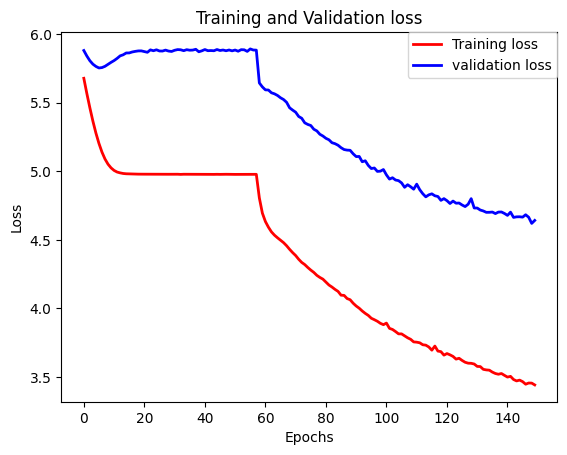

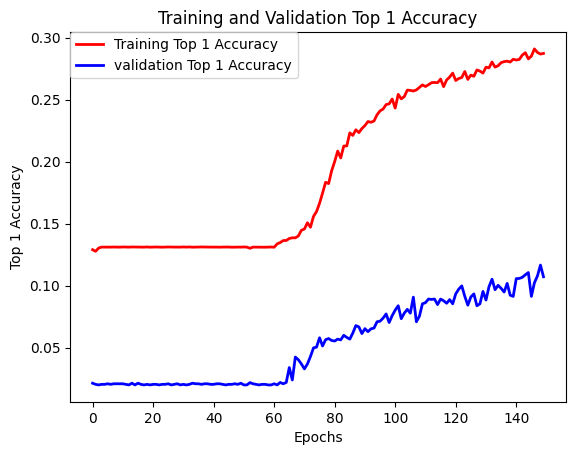

In [115]:
history_loss = {'train':list_train_loss_per_epoch, 'valid':list_valid_loss_per_epoch}
history_acc1 = {'train':list_train_acc1_per_epoch, 'valid':list_valid_acc1_per_epoch}

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Top 1 Acc: {:4f}, Top 5 Acc: {:4f}'.format(best_acc1,best_acc5))

#plot the loss and accuracy for train and valid
make_plot(history_loss, num_epochs, input_dir, type_plot='loss')
make_plot(history_acc1, num_epochs,input_dir, type_plot='acc1')



# load best model weights
model.load_state_dict(best_model_wts)
model.load_state_dict(best_model_wts)
state = {'epoch': best_epoch, 
        'state_dict': model.state_dict(), 
        'optimizer': optimizer.state_dict(), 
            'loss':epoch_loss,'valid_accuracy': best_acc1}

full_model_path =saved_dir+'/mixed_model_state_seed_97.tar'

torch.save(state, full_model_path)
# return model

In [116]:
vqa = np.load('/home/arunava/VQA_Med/test_dataset_pickle/test19_df.pkl', allow_pickle=True )

# input_test = 'test_dataset_pickle/test19_df.pkl'


In [117]:
vqa

ID         Task                                               Q  \
0    synpic54082     modality                         what modality is shown?   
1    synpic48556     modality                was the mri taken with contrast?   
2    synpic50696     modality    what type of contrast did this patient have?   
3    synpic37194     modality                   what imaging method was used?   
4    synpic31308     modality                         what modality is shown?   
..           ...          ...                                             ...   
495  synpic21789  abnormality                what is abnormal in the ct scan?   
496  synpic39878  abnormality           what is most alarming about this mri?   
497  synpic41525  abnormality       what is most alarming about this ct scan?   
498  synpic18173  abnormality  what is the primary abnormality in this image?   
499  synpic54143  abnormality  what is the primary abnormality in this image?   

                                                     A  \
0                                 cta - ct angiography   
1                                                   no   
2                                                   iv   
3                            us-d - doppler ultrasound   
4                                       an - angiogram   
..                                                 ...   
495                ossification of stylohyoid ligament   
496                                   cerebral infarct   
497                              epiploic appendagitis   
498                   pancreatic ductal adenocarcinoma   
499  anaplastic oligodendroglioma#multi-cystic comp...   

                                                  PATH  
0    /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
1    /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
2    /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
3    /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
4    /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
..                                                 ...  
495  /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
496  /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
497  /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
498  /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  
499  /home/arunava/VQA_Med/data/raw/ImageCLEF/test_...  

[500 rows x 5 columns]

In [118]:

def get_test_loader(input_dir,input_test, img_feat_vqa,batch_size, num_workers,size=228):
    test_vqa_dataset = VqaDataset(
            input_dir=input_dir,
            input_vqa=input_test,
            img_feat_vqa=img_feat_vqa,
            phase = 'test')
    data_loader = torch.utils.data.DataLoader(dataset=test_vqa_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=num_workers)
    return data_loader

batch_size = opt.BATCH_SIZE
num_workers = 0
image_size = opt.IMG_INPUT_SIZE

In [119]:
print('imput_test',input_test)
# Create the DataLoader for our dataset
test_data_loader = get_test_loader(
    input_dir = input_dir , 
    input_test = input_test, 
    img_feat_vqa = img_feat_test,
    batch_size = batch_size, 
    num_workers = num_workers,
    size = image_size )

imput_test test_dataset_pickle/test_val21_df.pkl


In [120]:
test_df_res = None
path_change = '/home/arunava'

since = time.time()
model.eval()


VisualBertClassification(
  (model): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=1984, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0): VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropou

In [121]:
results=[]
res={'Image_id':[],'Answer':[]}

In [122]:
for batch_idx,batch_sample in enumerate(test_data_loader):
    # print('batch_sample',batch_sample)
    image = batch_sample['image_feature'].to(device)
    image_id = batch_sample['image_id']
    questions = batch_sample['question']

    output = model(image,questions)
    preds = torch.argmax(output,dim=-1)
    preds = preds.cpu().detach().numpy()

    assert(len(preds) == len(image_id))
    ans_keys = list(answer_classes.keys())
    ans_values = list(answer_classes.values())
    
    for pred, image_name in zip(preds, image_id):
        index_ans = ans_values.index(pred)
        results.append({image_name+'|'+ans_keys[index_ans]})
        res['Image_id'].append(image_name)
        res['Answer'].append(ans_keys[index_ans])

/home/arunava/miniconda3/envs/vqamedenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [123]:
df = pd.DataFrame(results)
test_df_res = pd.DataFrame(res)
df.to_csv(path_change+'/submission_visualbert.csv', index=False) 

In [124]:
time_elapsed = time.time() - since
print('Evaluation complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Evaluation complete in 0m 1s


In [125]:
test_path = path_change + '/VQA_Med_2019_Dataset/Test/VQAMed2019Test'
# test_ref_path = test_path + '/VQAMed2019_Test_Questions_w_Ref_Answers.txt'
test_ref_path =  '/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2021/VQA-Med-2021-VQAnswering-Task1-New-ValidationSet.txt'
with open(test_ref_path) as f:
    lines = f.readlines()

dict_data = {'Image_id':[],
            'Category':[],
            'Question':[],
            'Answer':[]
            }

In [126]:
for element in lines:
    # print('element',element)
    pd_element = element.split('|')
    # print('pd_element',pd_element[0])
    dict_data['Image_id'].append(pd_element[0])
    # dict_data['Category'].append(pd_element[1])
    dict_data['Question'].append(pd_element[1])
    dict_data['Answer'].append(pd_element[2].strip("\n"))

In [127]:
test_df = pd.DataFrame(dict_data,columns=['Image_id','Question','Answer'])

pred = test_df_res['Answer'].to_list()

truelabels = test_df['Answer'].to_list()

test_df_res['truelabels'] = truelabels

In [128]:
test_df_res.to_csv(path+'/visualbert_result.csv',index=False)

cnt=0
for i in range(len(pred)):
    if(pred[i] == truelabels[i]): cnt=cnt+1


print((cnt/len(pred))*100)

5.800000000000001


In [129]:
image_ids = res['Image_id']
preds = res['Answer']
questions = dict_data['Question']
answers = dict_data['Answer']
Image_ids = dict_data['Image_id']
categories = dict_data['Category']

In [130]:
for i in range(len(image_ids)):
    if image_ids[i] != Image_ids[i]:
        print('mismatch at index',i)
        break

In [131]:
cnt=0
correct ={'modality': 0, 'plane': 0, 'organ': 0, 'abnormality': 0}
count ={'modality': 0, 'plane': 0, 'organ': 0, 'abnormality': 0}

In [132]:
for i in range(len(image_ids)):
    if (preds[i] == answers[i]): 
        cnt = cnt+1
        correct[categories[i]] = correct[categories[i]]+1
    count[categories[i]] = count[categories[i]]+1  


IndexError: list index out of range

In [ ]:
print('cnt',cnt)
print('correct',correct)
print('count',count)

cnt 257
correct {'modality': 86, 'plane': 82, 'organ': 83, 'abnormality': 6}
count {'modality': 125, 'plane': 125, 'organ': 125, 'abnormality': 125}
